In [6]:
library(dplyr)
library(tibble)
library(tidyr)

library(Biobase)
library(pvca)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
  

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [8]:
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/gpca.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/rvp.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


In [ ]:
quantify_batch <- function(X, metadata) {
  batch <- metadata[colnames(X), 'batch']
  class <- metadata[colnames(X), 'class']

  rvp <- RVP(t(X), batch, class)
  gpca <- gPCA.batchdetect(t(X), batch)
    
  # create expressionset from biobase package
  meta_metadata <- data.frame(labelDescription = colnames(metadata))
  pheno_data <- new(
    "AnnotatedDataFrame",
    data = metadata, varMetadata = meta_metadata
  )
  eset <- ExpressionSet(assayData = as.matrix(X), phenoData = pheno_data)
  pvca_obj <- pvcaBatchAssess(eset, c('batch', 'class'), 0.6)
  var_pcts <- as.vector(pvca_obj$dat)
  names(var_pcts) <- as.vector(pvca_obj$label)

  c(
    gpca = gpca$delta,
    pvca = var_pcts['batch'],
    rvp = rvp
  )
}

# Comparison with scRNA-seq metrics
- kBET may not quantify accurately batch corrected data with batch-class imbalance. Local distribution of batches differ across classes and are different from the global distribution of batches
- LISI may not work well on data with missing batch-class combinations

In [7]:
library(kBET)
library(lisi)

In [2]:
file <- '../data/batchqc/sizes/batchqc-2000.rds'
X <- t(readRDS(file))

In [115]:
n <- 2000
ncond <- n / 4
batch <- as.factor(rep(1:2, each = ncond * 2))
class <- rep(rep(LETTERS[1:2], each = ncond), 2)
metadata <- data.frame(batch, class)
rownames(metadata) <- rownames(X)

#### RVP

In [28]:
rvp <- RVP(X, batch, class)

In [40]:
var_X <- sum(apply(X, 2, var))
var_rvp <- rvp * var_X

#### kBET
- Only performs testing on a sub-sample of samples
- n_repeat: No. of repeats of sub-sampling to compute mean rejection rate
    - More subsamples the larger the number of samples tested
- Does it perform permutation tests to calculate expected rejection rate?
- What is the kBET heuristic to determine k?
- Why is kBET slow?

In [144]:
kbet_estimate <- kBET(X, batch, testSize = 2000, n_repeat = 1)

In [92]:
rejection_rate <- kbet_estimate$summary['mean', 'kBET.observed']
kbet_pvalues <- kbet_estimate$results$kBET.pvalue.test
print(kbet_estimate$summary)
# avg_pval <- kbet_estimate$average.pvalue
# print(kbet_estimate$params)

      kBET.expected kBET.observed kBET.signif
mean    0.006266667       0.48835           0
2.5%    0.001666667       0.42000           0
50%     0.005833333       0.48500           0
97.5%   0.011666667       0.55525           0


#### LISI
- k is a function of the perplexity parameter
- Why is LISI slow?

In [106]:
# assumes that X has undergone dim reduction
lisi_results <- compute_lisi(X, metadata, c('batch', 'class'))

## Variance due to batch effects
- Data sets of different sizes

In [31]:
# Computes variance due to batch effects in a balanced two-batch two-class dataset
var_batch <- function(n, p, delta) p * n / (n - 1) * (delta / 2)^2

In [32]:
p <- 8000
batch_delta <- 5000
sample_sizes <- seq(2000, 10000, 2000)

# variance due to batch effects
sigma2s <- sapply(sample_sizes, var_batch, p, batch_delta)
names(sigma2s) <- sample_sizes

## Different sizes

In [110]:
# dir <- '../data/out/batchqc/sizes/'
# files <- list.files(dir, pattern = 'RVP*', full.names = T)
# rvps <- sapply(files, readRDS)
# names(rvps) <- c(10000, 2000, 4000, 6000, 8000)
# rvp <- data.frame(rvp = rvps)
# rvp <- rvp[order(as.numeric(rownames(rvp))), , drop = F]
# file <- '../data/out/batchqc/sizes/rvp.tsv'
# write.table(rvp, file, quote = F, sep = '\t')

In [27]:
file <- '../data/out/batchqc/diff_sizes/rvp.tsv'
rvp <- read.table(file, sep = '\t')

In [28]:
# LISI
dir <- '../data/out/batchqc/diff_sizes'
files <- list.files(dir, pattern = 'LISI*', full.names = T)
files <- files[c(2:5,1)]
print(files)
lisi <- lapply(files, readRDS)
names(lisi) <- seq(2000, 10000, 2000)

lisi_means <- sapply(lisi, function(X) mean(data.matrix(X)))

[1] "../data/out/batchqc/diff_sizes/LISI-2000.rds" 
[2] "../data/out/batchqc/diff_sizes/LISI-4000.rds" 
[3] "../data/out/batchqc/diff_sizes/LISI-6000.rds" 
[4] "../data/out/batchqc/diff_sizes/LISI-8000.rds" 
[5] "../data/out/batchqc/diff_sizes/LISI-10000.rds"


In [29]:
# kBET
dir <- '../data/out/batchqc/diff_sizes'
files <- list.files(dir, pattern = 'kBET*', full.names = T)
files <- files[c(2:5,1)]
print(files)
kbets <- lapply(files, readRDS)
names(kbets) <- seq(2000, 10000, 2000)

rejection_rates <- sapply(kbets, function(x) x$summary$kBET.observed[1])
ks <- sapply(kbets, function(x) x$params$k0)

[1] "../data/out/batchqc/diff_sizes/kBET-2000.rds" 
[2] "../data/out/batchqc/diff_sizes/kBET-4000.rds" 
[3] "../data/out/batchqc/diff_sizes/kBET-6000.rds" 
[4] "../data/out/batchqc/diff_sizes/kBET-8000.rds" 
[5] "../data/out/batchqc/diff_sizes/kBET-10000.rds"


In [36]:
scrna_sizes <- data.frame(
  n = seq(2000, 10000, 2000),
  var = sigma2s, rvp = rvp, lisi = lisi_means,
  kbet_rejection_rate = rejection_rates, kbet_k = ks
)

In [40]:
# file <- '../data/out/batchqc/diff_sizes/scrna_sizes.tsv'
# write.table(scrna_sizes, file, quote = F, sep = '\t')

In [41]:
file <- '../data/out/batchqc/diff_sizes/scrna_sizes.tsv'
scrna_sizes <- read.table(file, sep = '\t')

In [69]:
dir <- '../data/batchqc/sizes'
files <- list.files(dir, full.names = T)
files <- files[c(2:5,1)]
print(files)

Xs <- lapply(files, readRDS)
names(Xs) <- seq(2000, 10000, 2000)
variance <- sapply(Xs, function(X) sum(apply(X, 1, var)))

[1] "../data/batchqc/sizes/batchqc-2000.rds" 
[2] "../data/batchqc/sizes/batchqc-4000.rds" 
[3] "../data/batchqc/sizes/batchqc-6000.rds" 
[4] "../data/batchqc/sizes/batchqc-8000.rds" 
[5] "../data/batchqc/sizes/batchqc-10000.rds"


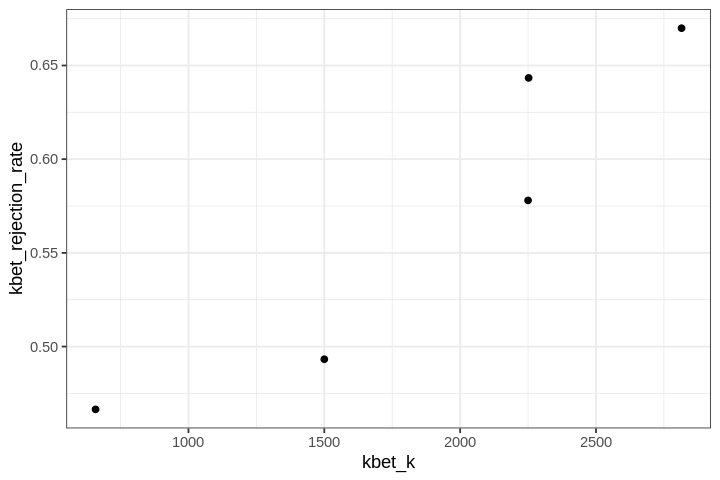

In [122]:
ax <- ggplot(scrna_sizes) +
  geom_point(aes(x = kbet_k, y = kbet_rejection_rate))
ax

In [121]:
file <- '~/Dropbox/tmp/sizes-rejectrate_k.pdf'
ggsave(file, ax, width = 5, height = 3)

In [96]:
long_sizes <- gather(scrna_sizes[, -6], 'metric', 'value', -c(n, var))

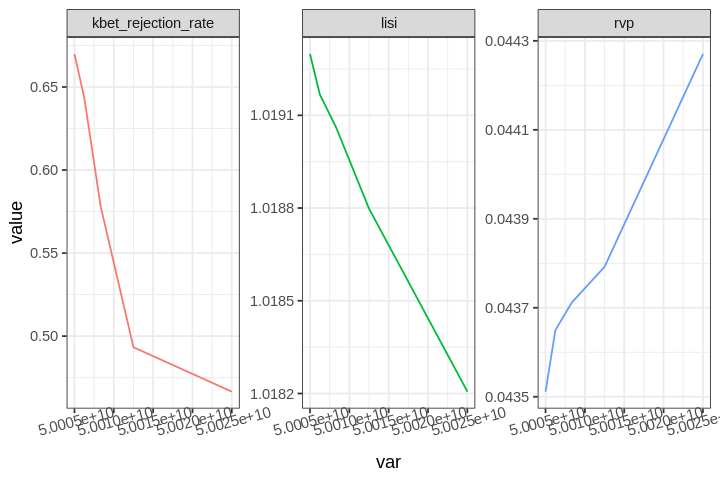

In [117]:
ax <- ggplot(long_sizes) +
  facet_wrap(~metric, scales = 'free_y') +
  geom_line(
    aes(x = var, y = value, col = metric),
    show.legend = FALSE
  ) +
  theme(axis.text.x = element_text(angle = 15))
ax

In [118]:
file <- '~/Dropbox/tmp/sizes-metric_var.pdf'
ggsave(file, ax, width = 9, height = 3)

## Different magnitudes (large)

#### Imbalanced

In [3]:
# Computes variance due to batch effects in a balanced two-batch two-class dataset
calc_batch_var <- function(delta, n, p) p * n / (n - 1) * (delta / 2)^2

batch_deltas <- seq(0, 10000, 1000)
p <- 8000
n <- 4000

# variance due to batch effects
sigma2s <- sapply(batch_deltas, calc_batch_var, n, p)
names(sigma2s) <- batch_deltas

In [128]:
# dir <- '../data/out/batchqc/diff_mag'
# files <- list.files(dir, pattern = 'RVP*', full.names = T)
# idx <- c(1:2, 4:11, 3)
# files <- files[idx]
# print(files)

# batch_deltas <- seq(0, 10000, 1000)
# rvps <- sapply(files, readRDS)
# names(rvps) <- batch_deltas
# rvp <- data.frame(rvp = rvps)
# file <- '../data/out/batchqc/diff_mag/rvp.tsv'
# write.table(rvp, file, quote = F, sep = '\t')

 [1] "../data/out/batchqc/diff_mag/RVP-0.rds"    
 [2] "../data/out/batchqc/diff_mag/RVP-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/RVP-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/RVP-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/RVP-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/RVP-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/RVP-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/RVP-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/RVP-8000.rds" 
[10] "../data/out/batchqc/diff_mag/RVP-9000.rds" 
[11] "../data/out/batchqc/diff_mag/RVP-10000.rds"


In [129]:
file <- '../data/out/batchqc/diff_mag/rvp.tsv'
rvp <- read.table(file, sep = '\t')

In [133]:
# LISI
dir <- '../data/out/batchqc/diff_mag'
files <- list.files(dir, pattern = 'LISI*', full.names = T)
idx <- c(1:2, 4:11, 3)
files <- files[idx]
print(files)

batch_deltas <- seq(0, 10000, 1000)
lisi <- lapply(files, readRDS)
names(lisi) <- batch_deltas
lisi_means <- sapply(lisi, function(X) mean(data.matrix(X)))

 [1] "../data/out/batchqc/diff_mag/LISI-0.rds"    
 [2] "../data/out/batchqc/diff_mag/LISI-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/LISI-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/LISI-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/LISI-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/LISI-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/LISI-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/LISI-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/LISI-8000.rds" 
[10] "../data/out/batchqc/diff_mag/LISI-9000.rds" 
[11] "../data/out/batchqc/diff_mag/LISI-10000.rds"


In [135]:
# kBET
dir <- '../data/out/batchqc/diff_mag'
files <- list.files(dir, pattern = 'kBET*', full.names = T)
files <- files[idx]
print(files)

kbets <- lapply(files, readRDS)
names(kbets) <- batch_deltas
rejection_rates <- sapply(kbets, function(x) x$summary$kBET.observed[1])
ks <- sapply(kbets, function(x) x$params$k0)

 [1] "../data/out/batchqc/diff_mag/kBET-0.rds"    
 [2] "../data/out/batchqc/diff_mag/kBET-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/kBET-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/kBET-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/kBET-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/kBET-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/kBET-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/kBET-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/kBET-8000.rds" 
[10] "../data/out/batchqc/diff_mag/kBET-9000.rds" 
[11] "../data/out/batchqc/diff_mag/kBET-10000.rds"


In [141]:
diff_mag_imbal <- data.frame(
  batch_delta = batch_deltas, var = sigma2s,
  rvp = rvp, lisi = lisi_means,
  kbet_rejection_rate = rejection_rates, kbet_k = ks
)

In [143]:
file <- '../data/out/batchqc/diff_mag/diff_mag_imbal.tsv'
write.table(diff_mag_imbal, file, quote = F, sep = '\t')

In [144]:
diff_mag_imbal

,batch_delta,var,rvp,lisi,kbet_rejection_rate,kbet_k
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0.0004072907,1.618961,0.5300,848
1000,1000,2000500125,0.0018041260,1.556665,0.5150,1128
2000,2000,8002000500,0.0060496307,1.295716,0.4650,1500
3000,3000,18004501125,0.0131952399,1.084864,0.3875,1105
4000,4000,32008002001,0.0232138328,1.023223,0.1250,942
5000,5000,50012503126,0.0360309379,1.018883,0.0500,568
6000,6000,72018004501,0.0515861444,1.020527,0.0100,755
7000,7000,98024506127,0.0695380212,1.060866,0.0925,1314
8000,8000,128032008002,0.0896962676,1.298058,0.2025,1221


In [148]:
long_diff_mag_imbal <- gather(
  diff_mag_imbal[, -6], 'metric', 'value',
  -c(batch_delta, var)
)

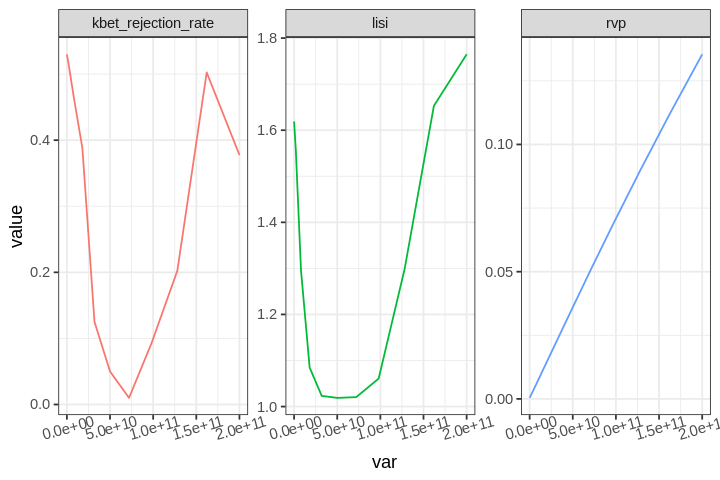

In [150]:
ax <- ggplot(long_diff_mag_imbal) +
  facet_wrap(~metric, scales = 'free_y') +
  geom_line(
    aes(x = var, y = value, col = metric),
    show.legend = FALSE
  ) +
  theme(axis.text.x = element_text(angle = 15))
ax

In [151]:
file <- '~/Dropbox/tmp/diff_mag-imbal.pdf'
ggsave(file, ax, width = 9, height = 3)

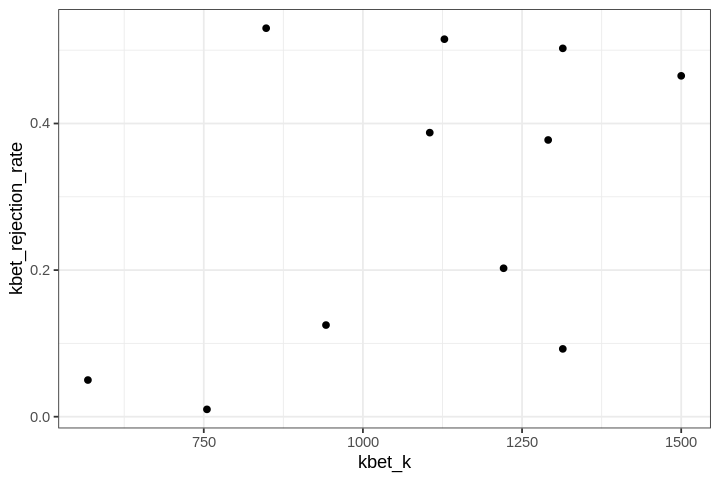

In [152]:
ax <- ggplot(diff_mag_imbal) +
  geom_point(aes(x = kbet_k, y = kbet_rejection_rate))
ax

In [153]:
file <- '~/Dropbox/tmp/diff_mag-rejrate_k.pdf'
ggsave(file, ax, width = 5, height = 3)

In [155]:
# kBET: k0 = 1000
dir <- '../data/out/batchqc/diff_mag'
files <- list.files(dir, pattern = 'kBET_k*', full.names = T)
files <- files[idx]
print(files)

kbets <- lapply(files, readRDS)
names(kbets) <- batch_deltas
rejection_rates <- sapply(kbets, function(x) x$summary$kBET.observed[1])
ks <- sapply(kbets, function(x) x$params$k0)

 [1] "../data/out/batchqc/diff_mag/kBET_k1000-0.rds"    
 [2] "../data/out/batchqc/diff_mag/kBET_k1000-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/kBET_k1000-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/kBET_k1000-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/kBET_k1000-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/kBET_k1000-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/kBET_k1000-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/kBET_k1000-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/kBET_k1000-8000.rds" 
[10] "../data/out/batchqc/diff_mag/kBET_k1000-9000.rds" 
[11] "../data/out/batchqc/diff_mag/kBET_k1000-10000.rds"


In [159]:
imbal_k1000 <- data.frame(
  batch_delta = batch_deltas, var = sigma2s,
  rvp = rvp, lisi = lisi_means,
  kbet_rejection_rate = rejection_rates
)

In [160]:
file <- '../data/out/batchqc/diff_mag/imbal_k1000.tsv'
write.table(imbal_k1000, file, quote = F, sep = '\t')

In [161]:
long_imbal_k1000 <- gather(
  imbal_k1000, 'metric', 'value',
  -c(batch_delta, var)
)

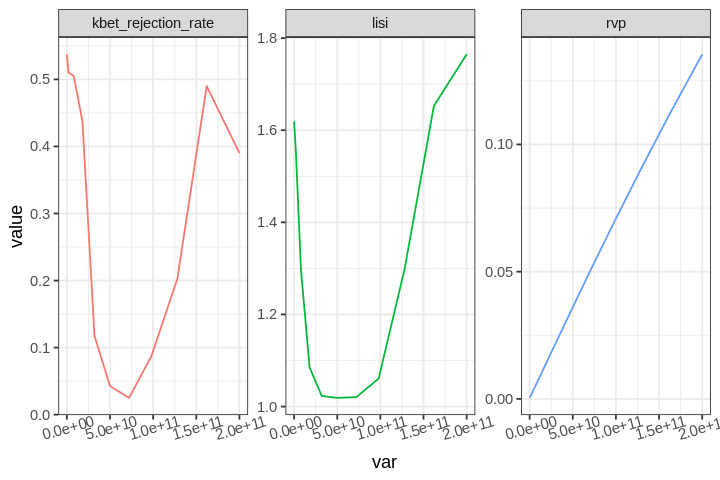

In [163]:
ax <- ggplot(long_imbal_k1000) +
  facet_wrap(~metric, scales = 'free_y') +
  geom_line(
    aes(x = var, y = value, col = metric),
    show.legend = FALSE
  ) +
  theme(axis.text.x = element_text(angle = 15))
ax

In [168]:
file <- '~/Dropbox/tmp/diff_mag-imbal_k1000.pdf'
ggsave(file, ax, width = 9, height = 3)

### Balanced

In [170]:
dir <- '../data/out/batchqc/diff_mag/balanced'
files <- list.files(dir, pattern = 'RVP*', full.names = T)
idx <- c(1:2, 4:11, 3)
files <- files[idx]
print(files)

batch_deltas <- seq(0, 10000, 1000)
rvps <- sapply(files, readRDS)
names(rvps) <- batch_deltas
rvp <- data.frame(rvp = rvps)
file <- '../data/out/batchqc/diff_mag/balanced/rvp.tsv'
write.table(rvp, file, quote = F, sep = '\t')

 [1] "../data/out/batchqc/diff_mag/balanced/RVP-0.rds"    
 [2] "../data/out/batchqc/diff_mag/balanced/RVP-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/balanced/RVP-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/balanced/RVP-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/balanced/RVP-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/balanced/RVP-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/balanced/RVP-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/balanced/RVP-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/balanced/RVP-8000.rds" 
[10] "../data/out/batchqc/diff_mag/balanced/RVP-9000.rds" 
[11] "../data/out/batchqc/diff_mag/balanced/RVP-10000.rds"


In [ ]:
# file <- '../data/out/batchqc/diff_mag/rvp.tsv'
# rvp <- read.table(file, sep = '\t')

In [173]:
# LISI
dir <- '../data/out/batchqc/diff_mag/balanced'
files <- list.files(dir, pattern = 'LISI*', full.names = T)
idx <- c(1:2, 4:11, 3)
files <- files[idx]
print(files)

batch_deltas <- seq(0, 10000, 1000)
lisi <- lapply(files, readRDS)
names(lisi) <- batch_deltas
lisi_means <- sapply(lisi, function(X) mean(data.matrix(X)))

 [1] "../data/out/batchqc/diff_mag/balanced/LISI-0.rds"    
 [2] "../data/out/batchqc/diff_mag/balanced/LISI-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/balanced/LISI-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/balanced/LISI-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/balanced/LISI-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/balanced/LISI-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/balanced/LISI-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/balanced/LISI-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/balanced/LISI-8000.rds" 
[10] "../data/out/batchqc/diff_mag/balanced/LISI-9000.rds" 
[11] "../data/out/batchqc/diff_mag/balanced/LISI-10000.rds"


In [175]:
# kBET
dir <- '../data/out/batchqc/diff_mag/balanced'
files <- list.files(dir, pattern = 'kBET_k*', full.names = T)
files <- files[idx]
print(files)

kbets <- lapply(files, readRDS)
names(kbets) <- batch_deltas
rejection_rates <- sapply(kbets, function(x) x$summary$kBET.observed[1])
ks <- sapply(kbets, function(x) x$params$k0)

 [1] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-0.rds"    
 [2] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-1000.rds" 
 [3] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-2000.rds" 
 [4] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-3000.rds" 
 [5] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-4000.rds" 
 [6] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-5000.rds" 
 [7] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-6000.rds" 
 [8] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-7000.rds" 
 [9] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-8000.rds" 
[10] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-9000.rds" 
[11] "../data/out/batchqc/diff_mag/balanced/kBET_k1000-10000.rds"


In [179]:
bal_k1000 <- data.frame(
  batch_delta = batch_deltas, var = sigma2s,
  rvp = rvp, lisi = lisi_means,
  kbet_rejection_rate = rejection_rates
)

In [180]:
file <- '../data/out/batchqc/diff_mag/balanced/bal_k1000.tsv'
write.table(bal_k1000, file, quote = F, sep = '\t')

In [181]:
long_bal_k1000 <- gather(
  bal_k1000, 'metric', 'value',
  -c(batch_delta, var)
)

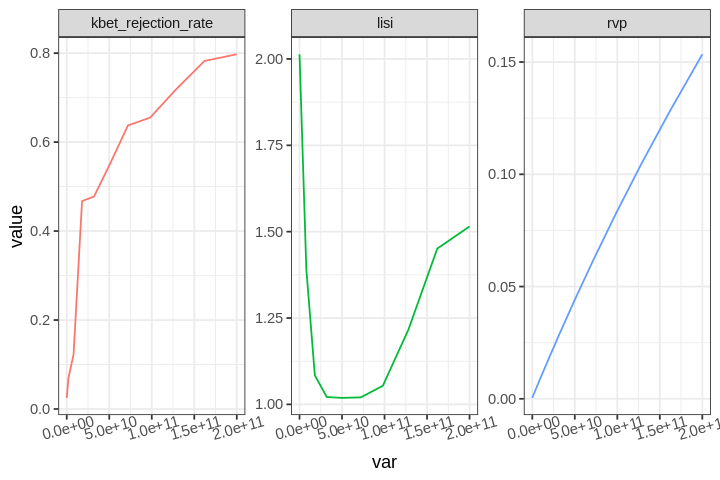

In [182]:
ax <- ggplot(long_bal_k1000) +
  facet_wrap(~metric, scales = 'free_y') +
  geom_line(
    aes(x = var, y = value, col = metric),
    show.legend = FALSE
  ) +
  theme(axis.text.x = element_text(angle = 15))
ax

In [183]:
file <- '~/Dropbox/tmp/diff_mag-bal_k1000.pdf'
ggsave(file, ax, width = 9, height = 3)

In [ ]:
# TODO: Run kbet class wise

In [194]:
dir <- '../data/batchqc/large/imbalanced'
files <- list.files(dir, full.names = T)
idx <- c(1:2, 4:11, 3)
files <- files[idx]
print(files)

 [1] "../data/batchqc/large/imbalanced/imbal_large-0.rds"    
 [2] "../data/batchqc/large/imbalanced/imbal_large-1000.rds" 
 [3] "../data/batchqc/large/imbalanced/imbal_large-2000.rds" 
 [4] "../data/batchqc/large/imbalanced/imbal_large-3000.rds" 
 [5] "../data/batchqc/large/imbalanced/imbal_large-4000.rds" 
 [6] "../data/batchqc/large/imbalanced/imbal_large-5000.rds" 
 [7] "../data/batchqc/large/imbalanced/imbal_large-6000.rds" 
 [8] "../data/batchqc/large/imbalanced/imbal_large-7000.rds" 
 [9] "../data/batchqc/large/imbalanced/imbal_large-8000.rds" 
[10] "../data/batchqc/large/imbalanced/imbal_large-9000.rds" 
[11] "../data/batchqc/large/imbalanced/imbal_large-10000.rds"


In [197]:
# metadata
n <- 6000
ncond <- n / 4
batch <- as.factor(rep(1:2, each = ncond * 2))
class <- rep(rep(LETTERS[1:2], each = ncond), 2)
metadata <- data.frame(batch, class)
idx <- c(501:2500, 3501:5500)
metadata <- metadata[idx, ]

X <- readRDS(files[1])
sids <- colnames(X)[idx]
rownames(metadata) <- sids

In [202]:
for (batch_delta in batch_deltas) {
  file <- sprintf(
    "../data/batchqc/large/imbalanced/imbal_large-%d.rds", batch_delta
  )
  print(file)
  X <- readRDS(file)
  ax <- ggplot_pca(X[, idx], metadata, col = 'batch', pch = 'class')
  outfile <- sprintf('~/Dropbox/tmp/pca-bal_%d.pdf', batch_delta)
  ggsave(outfile, ax, width = 6, height = 4)
}

[1] "../data/batchqc/large/imbalanced/imbal_large-0.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-1000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-2000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-3000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-4000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-5000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-6000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-7000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-8000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-9000.rds"
[1] "../data/batchqc/large/imbalanced/imbal_large-10000.rds"
